In [6]:
baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"c9a75a056da4fcd072dbe6951190537d"}
import requests

def get(path, params=None):
# make HTTP GET request to path
    headers = {"api-key":"c9a75a056da4fcd072dbe6951190537d"}
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
    with open(filename, 'wb') as f:
         f.write(r.content)
    return filename # return the filename string

    return r

Check base simulations

In [16]:
r=get(baseUrl)
names = [sim['name'] for sim in r['simulations']]


In [17]:
names

[u'Illustris-1',
 u'Illustris-1-Dark',
 u'Illustris-2',
 u'Illustris-2-Dark',
 u'Illustris-3',
 u'Illustris-3-Dark',
 u'TNG100-1',
 u'TNG100-1-Dark',
 u'TNG100-2',
 u'TNG100-2-Dark',
 u'TNG100-3',
 u'TNG100-3-Dark',
 u'TNG300-3',
 u'TNG300-2-Dark',
 u'TNG300-2',
 u'TNG300-1-Dark',
 u'TNG300-1',
 u'TNG300-3-Dark',
 u'Illustris-1-Subbox0',
 u'Illustris-1-Subbox1',
 u'Illustris-1-Subbox2',
 u'Illustris-1-Subbox3',
 u'Illustris-2-Subbox0',
 u'Illustris-2-Subbox1',
 u'Illustris-2-Subbox2',
 u'Illustris-2-Subbox3',
 u'Illustris-3-Subbox0',
 u'Illustris-3-Subbox1',
 u'Illustris-3-Subbox2',
 u'Illustris-3-Subbox3',
 u'TNG100-1-Subbox0',
 u'TNG100-1-Subbox1',
 u'TNG100-2-Subbox0',
 u'TNG100-2-Subbox1',
 u'TNG100-3-Subbox0',
 u'TNG100-3-Subbox1',
 u'TNG300-3-Subbox1',
 u'TNG300-3-Subbox2',
 u'TNG300-3-Subbox0',
 u'TNG300-2-Subbox1',
 u'TNG300-2-Subbox2',
 u'TNG300-2-Subbox0',
 u'TNG300-1-Subbox1',
 u'TNG300-1-Subbox2',
 u'TNG300-1-Subbox0']

In [77]:
mass_min = 10**11.9 / 1e10 *0.704
mass_max = 10**12.1 / 1e10 *0.704

search_query = "?mass__gt=" + str(mass_min) + "&mass__lt=" + str(mass_max)

url = "http://www.tng-project.org/api/TNG100-1/snapshots/z=0/subhalos/" + search_query

subhalos = get(url)

# Number of relevant subhalos
print(subhalos['count'])



1080


Find first five relevant subhalos at z = 0:

In [78]:
ids = [ subhalos['results'][i]['id'] for i in range(5) ]
print(ids)

[14, 17, 18, 20, 22]


In [81]:
import h5py
import numpy as np

which_sim = 'TNG100-1'
id = 14
redshift = 0.0
params = {'stars':'GFM_Metals,GFM_StellarFormationTime'}

scale_factor = 1.0 / (1+redshift)
little_h = 0.704
solar_Z = 0.0127

url = "http://www.tng-project.org/api/"+str(which_sim)+"/snapshots/z=" + str(redshift) + "/subhalos/" + str(id)
print(url)
sub = get(url) # get json response of subhalo properties
saved_filename = get(url + "/cutout.hdf5",params) # get and save HDF5 cutout file

http://www.tng-project.org/api/TNG100-1/snapshots/z=0.0/subhalos/14


In [ ]:
f=h5py.File(saved_filename)
all_metal_fractions = f['PartType4']['GFM_Metals'][:]
metal_names=['H', 'He', 'C', 'N', 'O','Ne', 'Mg', 'Si', 'Fe','rest']
star_formation_time_scale_factor= f['PartType4']['GFM_StellarFormationTime'][:]

In [115]:
# Import solar abundances
import os
os.chdir('/home/oliver/ChempyMulti/')
from Chempy.solar_abundance import solar_abundances
solar=solar_abundances()
getattr(solar,'Asplund09')()

solar_fractions = []
for i in range(len(metal_names)):
    for j in range(len(solar.all_elements)):
        if solar.all_elements[j]==metal_names[i]:
            solar_fractions.append(solar.fractions[j])
            break


In [123]:
all_abuns = np.zeros([len(all_metal_fractions),8])
for i in range(1,8):
    all_abuns[:,i-1]=np.log10(all_metal_fractions[:,i]/all_metal_fractions[:,8])-np.log10(solar_fractions[i]/solar_fractions[8])
all_abuns[:,7]=np.log10(all_metal_fractions[:,8]/all_metal_fractions[:,0])-np.log10(solar_fractions[8]/solar_fractions[0])

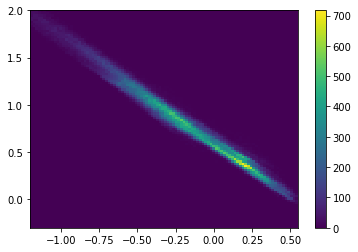

In [135]:
import matplotlib.pyplot as plt
plt.hist2d(all_abuns[:,-1],all_abuns[:,4]-all_abuns[:,-1],bins=100,range=[[-1.2,0.55],[-0.3,2]]);
plt.colorbar()

In [125]:
np.savez('single_galaxy_TNG_abun',galaxy_index=id,simulation=which_sim,redshift=redshift,
         elements=metal_names,metal_abundances=all_abuns)

(181244, 8)

In [90]:
H_index

(array([], dtype=int64),)

In [56]:
ff=f['PartType4']
print(ff['GFM_Metals'][:])

[[6.97522521e-01 2.60323972e-01 4.65612672e-03 ... 1.72789267e-03
  1.69816788e-03 9.54122515e-04]
 [7.29375601e-01 2.50294209e-01 1.80620328e-03 ... 8.58818763e-04
  6.33493997e-04 4.31123626e-04]
 [6.73260808e-01 2.70379603e-01 6.54468872e-03 ... 2.30360241e-03
  2.62221624e-03 1.37329276e-03]
 ...
 [7.41879821e-01 2.48562321e-01 9.64688428e-04 ... 4.36709059e-04
  4.84790449e-04 2.78658641e-04]
 [7.41067767e-01 2.47793376e-01 9.82807018e-04 ... 5.03072864e-04
  4.15095041e-04 2.77052954e-04]
 [7.55702198e-01 2.41850585e-01 1.15483075e-04 ... 1.11346228e-04
  5.85147027e-05 5.55702172e-05]]


In [61]:
ff['GFM_StellarFormationTime'][:]

array([0.19171143, 0.13964944, 0.20660082, ..., 0.3868005 , 0.3357326 ,
       0.24875507], dtype=float32)

In [65]:
ff['GFM_MetalsTagged'][:]

array([[9.0689055e-04, 3.7806232e-02, 3.4404143e-03, 2.1186993e-03,
        4.9365772e-04, 1.1012619e-03],
       [2.6155429e-04, 1.9576987e-02, 4.9166888e-04, 3.1098558e-04,
        1.4314937e-04, 4.8320933e-04],
       [1.6935718e-03, 4.5719147e-02, 8.9469124e-03, 4.3223961e-03,
        9.1501931e-04, 1.4034363e-03],
       ...,
       [4.7836083e-04, 7.4798502e-03, 1.5996499e-03, 1.5364431e-03,
        2.5447318e-04, 1.8637045e-04],
       [3.2172166e-04, 9.9975476e-03, 8.1958505e-04, 8.3742948e-04,
        1.6801203e-04, 2.3282628e-04],
       [3.9669150e-05, 2.2940210e-03, 1.1350744e-04, 7.8073877e-05,
        1.9030513e-05, 3.7282891e-05]], dtype=float32)

In [58]:
ff.items()

[(u'BirthPos', <HDF5 dataset "BirthPos": shape (22579, 3), type "<f4">),
 (u'BirthVel', <HDF5 dataset "BirthVel": shape (22579, 3), type "<f4">),
 (u'Coordinates', <HDF5 dataset "Coordinates": shape (22579, 3), type "<f8">),
 (u'GFM_InitialMass',
  <HDF5 dataset "GFM_InitialMass": shape (22579,), type "<f4">),
 (u'GFM_Metallicity',
  <HDF5 dataset "GFM_Metallicity": shape (22579,), type "<f4">),
 (u'GFM_Metals', <HDF5 dataset "GFM_Metals": shape (22579, 10), type "<f4">),
 (u'GFM_MetalsTagged',
  <HDF5 dataset "GFM_MetalsTagged": shape (22579, 6), type "<f4">),
 (u'GFM_StellarFormationTime',
  <HDF5 dataset "GFM_StellarFormationTime": shape (22579,), type "<f4">),
 (u'GFM_StellarPhotometrics',
  <HDF5 dataset "GFM_StellarPhotometrics": shape (22579, 8), type "<f4">),
 (u'Masses', <HDF5 dataset "Masses": shape (22579,), type "<f4">),
 (u'ParticleIDs', <HDF5 dataset "ParticleIDs": shape (22579,), type "<u8">),
 (u'Potential', <HDF5 dataset "Potential": shape (22579,), type "<f4">),
 (u'S

In [66]:
import h5py
import numpy as np

which_sim = 'TNG100-1'
id = 21
redshift = 0.0
params = {'gas':'all'}

scale_factor = 1.0 / (1+redshift)
little_h = 0.704
solar_Z = 0.0127

url = "http://www.tng-project.org/api/"+str(which_sim)+"/snapshots/z=" + str(redshift) + "/subhalos/" + str(id)
print(url)
sub = get(url) # get json response of subhalo properties
saved_filename = get(url + "/cutout.hdf5",params) # get and save HDF5 cutout file

http://www.tng-project.org/api/TNG300-1/snapshots/z=0.0/subhalos/21


In [76]:
f2=h5py.File(saved_filename)
ff2=f2['PartType4']
ff2.items()
ff2['GFM_Metals'][:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [74]:
ff2['GFM_MetalsTagged'][:]

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
 import h5py
>>> import numpy as np
>>>
>>> id = 109974
>>> redshift = 2.0
>>> params = {'stars':'Coordinates,GFM_Metallicity'}
>>>
>>> scale_factor = 1.0 / (1+redshift)
>>> little_h = 0.704
>>> solar_Z = 0.0127
>>>
>>> url = "http://www.tng-project.org/api/Illustris-1/snapshots/z=" + str(redshift) + "/subhalos/" + str(id)
>>> sub = get(url) # get json response of subhalo properties
>>> saved_filename = get(url + "/cutout.hdf5",params) # get and save HDF5 cutout file
>>>
>>> with h5py.File(saved_filename) as f:
>>>     # NOTE! If the subhalo is near the edge of the box, you must take the periodic boundary into account! (we ignore it here)
>>>     dx = f['PartType4']['Coordinates'][:,0] - sub['pos_x']
>>>     dy = f['PartType4']['Coordinates'][:,1] - sub['pos_y']
>>>     dz = f['PartType4']['Coordinates'][:,2] - sub['pos_z']
>>>     metals = f['PartType4']['GFM_Metallicity'][:]
>>> 
>>>     rr = np.sqrt(dx**2 + dy**2 + dz**2)
>>>     rr *= scale_factor/little_h # ckpc/h -> physical kpc
>>> 
>>>     w = np.where( (rr >= 3.0) & (rr < 5.0) )    
>>>     print np.mean( metals[w] ) / solar_Z

0.248392603881

In [9]:
# first convert log solar masses into group catalog units
>>> mass_min = 10**11.9 / 1e10 * 0.704
>>> mass_max = 10**12.1 / 1e10 * 0.704

>>> # form the search_query string by hand for once
>>> search_query = "?mass__gt=" + str(mass_min) + "&mass__lt=" + str(mass_max)
>>> search_query
'?mass__gt=55.9207077246&mass__lt=88.6283489903'

>>> # form the url and make the request
>>> a
>>> subhalos = get(url)
>>> subhalos['count']
550

>>> ids = [ subhalos['results'][i]['id'] for i in range(5) ]
>>> ids
[109974, 110822, 123175, 107743, 95711]

[u'gasmetallicitysfr',
 u'massinrad_bhs',
 u'supplementary_data',
 u'starmetallicity',
 u'stellarphotometrics_b',
 u'grnr',
 u'spin_x',
 u'massinhalfrad_gas',
 u'stellarphotometrics_i',
 u'stellarphotometricsmassinrad',
 u'stellarphotometrics_k',
 u'primary_flag',
 u'stellarphotometrics_u',
 u'massinmaxrad_stars',
 u'stellarphotometrics_g',
 u'meta',
 u'mass_log_msun',
 u'len_bhs',
 u'massinrad_stars',
 u'windmass',
 u'vel_z',
 u'veldisp',
 u'id',
 u'massinhalfrad_stars',
 u'parent',
 u'vis',
 u'sfrinmaxrad',
 u'halfmassrad_bhs',
 u'vmaxrad',
 u'gasmetallicitysfrweighted',
 u'starmetallicitymaxrad',
 u'halfmassrad_dm',
 u'trees',
 u'halfmassrad_stars',
 u'massinhalfrad_bhs',
 u'massinmaxrad_gas',
 u'massinrad',
 u'mass_dm',
 u'vel_y',
 u'mass_bhs',
 u'stellarphotometrics_z',
 u'snap',
 u'spin_z',
 u'massinhalfrad',
 u'sfrinrad',
 u'gasmetallicityhalfrad',
 u'sfrinhalfrad',
 u'cutouts',
 u'mass_stars',
 u'stellarphotometrics_r',
 u'cm_y',
 u'cm_x',
 u'bhmdot',
 u'cm_z',
 u'massinrad_dm'